In [1]:
import pickle
from itertools import chain
from matplotlib.collections import LineCollection
from matplotlib import markers
from matplotlib.path import Path
import math
import numpy as np
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker

In [2]:
ratios = pd.read_csv("../data/Figure3a_Data.csv")

In [3]:
ratios_alleles = pd.read_csv("../data/Figure3b_Data.tsv",sep="\t")
ratios_alleles = ratios_alleles.iloc[::-1].reset_index(drop=True)

In [4]:
#ratios_alleles = ratios_alleles.sort_values(by="Gains").reset_index(drop=True)

In [4]:
with open("../data/Figure3b_Data_micromacro.pkl", "rb") as fh:
    gcstar = pickle.load(fh)

In [45]:
#ratios = ratios[ratios["motif"].transform(lambda x: len(x)<10)]

In [5]:
from ete3 import Tree, NodeStyle

def round_sig(x, sig=2):
    return round(x, sig - int(math.floor(np.log10(abs(x)))) - 1)


def to_coord(x, y, xmin, xmax, ymin, ymax, plt_xmin, plt_ymin, plt_width, plt_height):
    x = (x - xmin) / (xmax - xmin) * plt_width  + plt_xmin
    y = (y - ymin) / (ymax - ymin) * plt_height + plt_ymin
    return x, y


def plot_tree(tree, align_names=False, name_offset=None, max_dist=None, font_size=9, axe=None, **kwargs):
    """
    Plots a ete3.Tree object using matploltib.
    
    :param tree: ete Tree object
    :param False align_names: if True names will be aligned vertically
    :param None max_dist: if defined any branch longer than the given value will be 
       reduced by this same value.
    :param None name_offset: offset relative to tips to write leaf_names. In bL scale
    :param 12 font_size: to write text
    :param None axe: a matploltib.Axe object on which the tree will be painted.
    :param kwargs: for tree edge drawing (matplotlib LineCollection) 
    :param 1 ms: marker size for tree nodes (relative to number of nodes)
    
    :returns: a dictionary of node objects with their coordinates
    """
    
    if axe is None:
        axe = plt.subplot(111)

    
    def __draw_edge_nm(c, x):
        h = node_pos[c]
        hlinec.append(((x, h), (x + c.dist, h)))
        hlines.append(cstyle)
        return (x + c.dist, h)

    def __draw_edge_md(c, x):
        h = node_pos[c]
        if c in cut_edge:
            offset = max_x / 600.
            hlinec.append(((x, h), (x + c.dist / 2 - offset, h)))
            hlines.append(cstyle)
            hlinec.append(((x + c.dist / 2 + offset, h), (x + c.dist, h)))
            hlines.append(cstyle)
            hlinec.append(((x + c.dist / 2, h - 0.05), (x + c.dist / 2 - 2 * offset, h + 0.05)))
            hlines.append(cstyle)
            hlinec.append(((x + c.dist / 2 + 2 * offset, h - 0.05), (x + c.dist / 2, h + 0.05)))
            hlines.append(cstyle)
            axe.text(x + c.dist / 2, h - 0.07, '+%g' % max_dist, va='top', 
                     ha='center', size=2. * font_size / 3)
        else:
            hlinec.append(((x, h), (x + c.dist, h)))
            hlines.append(cstyle)
        return (x + c.dist, h)

    __draw_edge = __draw_edge_nm if max_dist is None else __draw_edge_md
    
    vlinec = []
    vlines = []
    hlinec = []
    hlines = []
    nodes = []
    nodex = []
    nodey = []
    ali_lines = []
    
    # to align leaf names
    tree = tree.copy()
    max_x = max(n.get_distance(tree) for n in tree.iter_leaves())

    coords = {}
    node_pos = dict((n2, i) for i, n2 in enumerate(tree.get_leaves()[::-1]))
    node_list = tree.iter_descendants(strategy='postorder')
    node_list = chain(node_list, [tree])

    # reduce branch length
    cut_edge = set()
    if max_dist is not None:
        for n in tree.iter_descendants():
            if n.dist > max_dist:
                n.dist -= max_dist
                cut_edge.add(n)

    if name_offset is None:
        name_offset = max_x / 100.
    # draw tree
    for n in node_list:
        style = n._get_style()
        x = __builtin__.sum(n2.dist for n2 in n.iter_ancestors()) + n.dist
        if n.is_leaf():
            y = node_pos[n]
            #tls = {"Vipera_berus": "European_adder", "Pantherophis_guttatus":"Corn_snake", "Thamnophis_elegans":"Garter_snake"}
            tls = {"Pantherophis_obsoletus": "Black rat_snake", "Pantherophis_guttatus":"Corn_snake", "Vipera_berus": "European_viper"}
            name = "\n".join(tls[n.name].split("_"))
            if align_names:
                axe.text(max_x + name_offset, y, "{}".format(name),
                         va='center', size=font_size) #, style='italic'
                ali_lines.append(((x, y), (max_x + name_offset, y)))
            else:
                axe.text(x + name_offset, y, "{}".format(name),
                         va='center', size=font_size)
        else:
            y = np.mean([node_pos[n2] for n2 in n.children])
            node_pos[n] = y

            # draw vertical line
            vlinec.append(((x, node_pos[n.children[0]]), (x, node_pos[n.children[-1]])))
            vlines.append(style)

            # draw horizontal lines
            for child in n.children:
                cstyle = child._get_style()
                coords[child] = __draw_edge(child, x)
        nodes.append(style)
        nodex.append(x)
        nodey.append(y)

    # draw root
    __draw_edge(tree, 0)

    lstyles = ['-', '--', ':']
    hline_col = LineCollection(hlinec, colors=[l['hz_line_color'] for l in hlines], 
                              linestyle=[lstyles[l['hz_line_type']] for l in hlines],
                              linewidth=[(l['hz_line_width'] + 1.) / 2 for l in hlines])
    vline_col = LineCollection(vlinec, colors=[l['vt_line_color'] for l in vlines], 
                              linestyle=[lstyles[l['vt_line_type']] for l in vlines],
                              linewidth=[(l['vt_line_width'] + 1.) / 2 for l in vlines])
    ali_line_col = LineCollection(ali_lines, colors='k')

    axe.add_collection(hline_col)
    axe.add_collection(vline_col)
    axe.add_collection(ali_line_col)
    axe.scatter(0,0, s=0)
    return coords

def plot_lowess(x, y, **kwargs):
    '''Plots lowess line depending on fraction'''

    z = lowess(np.array(y),np.array(x),frac=0.08)
    y2 = z[:,1]
    plt.plot(x,y2, **kwargs)
    
def subplot_lowess(x, y, ax, frac, **kwargs):
    '''Plots lowess line depending on fraction'''

    z = lowess(np.array(y),np.array(x),frac=frac)
    y2 = z[:,1]
    ax.plot(x,y2, **kwargs)

def control_ylim(x, y, **kwargs):
    maxy = max(y)
    miny = min(y)
    print(maxy, miny)
    plt.ylim([miny,maxy])
    

<ipython-input-6-b9d8ba787da3>:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs["A"].set_xticklabels(["", 40,30,20,10,0])


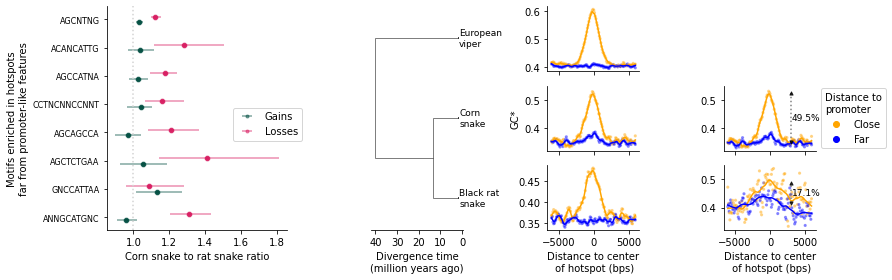

In [6]:
mosaic = '''
XXXAABBEE
XXXAABBEE
XXXAACCFF
XXXAACCFF
XXXAADDGG
XXXAADDGG
'''
f, axs = plt.subplot_mosaic(mosaic,
                            figsize=[12.5,4])

## Motifs 
ax = axs["X"]
colors = ["#004D40", "#D81B60"]
kinds = ["gains", "loses"]
pad = [-0.1, 0.1]
morder = ['AGCNTNG','ACANCATTG','AGCCATNA','CCTNCNNCCNNT','AGCAGCCA','AGCTCTGAA','GNCCATTAA','ANNGCATGNC'][::-1]

for i,kind in enumerate(kinds):
    subset = ratios[(ratios["kind"] == kind)] 
    subset = subset.reset_index(drop=True) 
#    if kind=="gains":
#        morder = subset.sort_values(by="ratio").motif.values
    subset = subset.set_index("motif").loc[morder].reset_index()
    subset["ycor"] = subset.index + pad[i]
    sns.scatterplot(data=subset, x="ratio", y="ycor", color=colors[i], ax=ax, alpha=0.9)
    lower_error = abs(subset["ratio"] - subset["low_ratio"])
    upper_error = abs(subset["high_ratio"] - subset["ratio"])
    asymmetric_error = [lower_error, upper_error]
    ax.errorbar(subset["ratio"], subset["ycor"], xerr=asymmetric_error, fmt='.', 
                 capsize=0, alpha=0.5, label=kind.capitalize().replace("Loses", "Losses"), color=colors[i])

ax.set_yticks(range(len(subset)))
ax.set_yticklabels(subset.motif, fontsize=8)
#ax.set_xlim([0.7, 1.7])
ax.axvline(x=1, color="lightgray", linestyle="dotted")
ax.legend(loc=(0.7, 0.4))
ax.set_ylabel("Motifs enriched in hotspots\nfar from promoter-like features")
ax.set_xlabel("Corn snake to rat snake ratio")

## GC*

#nwk = "((Pantherophis_obsoletus:34.71135000,Pantherophis_guttatus:34.71135000)'14':3.47835000,Vipera_berus:38.18970000);"
nwk = "(Vipera_berus:38.1897, (Pantherophis_guttatus:11.59544,Pantherophis_obsoletus:11.59544):26.59426);"
t = Tree(nwk, format=1)
plot_tree(t,align_names=True, axe=axs["A"])

axs["A"].set_xticklabels(["", 40,30,20,10,0])

pal = {"Close":"orange", 
       "Far":"blue"}

ax = axs["A"]
margin = 0.4
ax.set_ylim([-margin, 2+abs(margin)])
ax.set_xlabel("Divergence time\n(million years ago)")
#ax.spines['left'].set_visible(False)
#ax.tick_params(left=False, labelleft=False)

gc_axs = ["B","C","D", 
          "E", "F", "G"]
ctypes = ["all", "all", "all", 
          None, "macro", "micro", None]
species = ["Vipera_berus",
           "Pantherophis_guttatus", 
           "Pantherophis_obsoletus",
           None,
           "Pantherophis_guttatus", 
           "Pantherophis_guttatus", 
           None]

for i,l in enumerate(gc_axs):
    ax = axs[l]
    if species[i]==None:
        continue
    subd = gcstar[species[i]]
    ctype = ctypes[i]
    subd = subd[(subd.hue_kind.str.contains("hots")) & (subd.ctype==ctype)]
    subd = subd.replace("hotspots.close", "Close").replace("hotspots.far", "Far")
    sns.scatterplot(subd, x="rel_pos", 
                    y="gcstar", 
                    hue="hue_kind", 
                    s = 10,
                    palette=pal,
                    ax=ax, 
                    legend=False if l!="F" else True,
                    alpha=0.5)
    for dist,df in subd.groupby("hue_kind"):
        subplot_lowess(df.rel_pos, df.gcstar, ax, 0.07 if l!="G" else 0.2, c=pal[dist])

    ax.set_ylabel("")
    ax.set_xlabel("")
    sns.despine()

    if l=="F":
        labels = ["<= 500bp","> 500bp"] 
        ax.legend(title="Distance to\npromoter",
                  loc='center left', 
                  bbox_to_anchor=(1, 0.5))
        
    if l=="C":
        ax.set_ylabel("GC*")
        
    if l in ["C", "F", "G"]:
        ax.set_ylim([0.32,0.55])
        if l!="C":
            subd = gcstar[species[i]]
            subd = subd[(subd.hue_kind.str.contains("hotspots.close")) & (subd.ctype==ctype)]
            epice = subd[subd.rel_pos.between(-200,200)].groupby(["branch","hue_kind","ctype"])["gcstar"].mean().reset_index().gcstar[0]
            flank = subd[(subd.rel_pos.between(-5000,-3000)) | (subd.rel_pos.between(3000,5000))].groupby(["branch","hue_kind","ctype"])["gcstar"].mean().reset_index().gcstar[0]
            fold = (epice/flank)-1
            ax.plot([3e3, 3e3], [flank, epice], linestyle="dotted", color="gray")
            ax.scatter(3e3, flank, marker="v", color="black", alpha=0.8, s=10, zorder=10)
            ax.scatter(3e3, epice, marker="^", color="black", alpha=0.8, s=10, zorder=10)
            ax.annotate("{:.1f}%".format(fold*100), xy=(3.1e3, np.average([flank, epice])), fontsize=9, va="center")
            #ax.annotate("", xy=(3e3, flank), xytext=(3e3, flank), arrowprops=dict(arrowstyle="->"))
            #ax.annotate('', xy=[3e3, epice],xytext=[3e3, flank],arrowprops=dict(arrowstyle='<->')
            
            #ax.arrow(3e3, flank, 0, epice-flank, head_width=500, head_length=0, fc='blue', ec='black')
        
    if l!="D" and l!="G":
        ax.set_xticklabels([])
        
    if l=="D" or l=="G":
        ax.set_xlabel("Distance to center\n of hotspot (bps)")
        
    
for l in ["A", "E"]:
    axs[l].spines['left'].set_visible(False)
    axs[l].tick_params(left=False, labelleft=False)
    if l=="A":
        axs[l].xaxis.set_major_locator(ticker.MultipleLocator(10))
    if l!="A":
        axs[l].spines['bottom'].set_visible(False)
        axs[l].tick_params(bottom=False, labelbottom=False)
    
plt.tight_layout()
#plt.savefig("../pdfs/Figure3.pdf")
#plt.savefig("../pdfs/Figure3.jpg", dpi=400)

In [7]:
gcstar_df = pd.concat(gcstar.values())

<ipython-input-8-0a6e63003253>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subd['hue_kind'] = subd['hue_kind'].replace({'coldspots.close': 'Coldspots close',


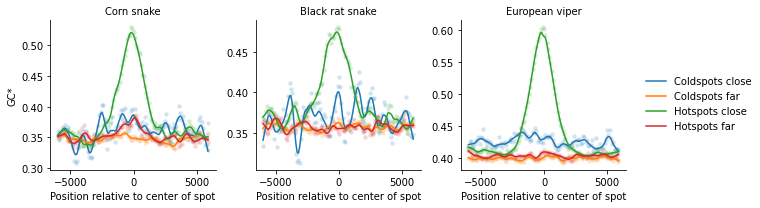

In [8]:
subd = gcstar_df[(gcstar_df.ctype=="all") & (~gcstar_df.branch.str.contains("Crot"))]
subd['hue_kind'] = subd['hue_kind'].replace({'coldspots.close': 'Coldspots close', 
                                             'coldspots.far': 'Coldspots far',
                                             'hotspots.close': 'Hotspots close',
                                             'hotspots.far': 'Hotspots far',
                                            })

g = sns.FacetGrid(data=subd, col="branch", hue="hue_kind", sharey=False)
g.map(sns.scatterplot, "rel_pos", "gcstar", s=20, alpha=0.2)
g.map(plot_lowess, "rel_pos", "gcstar")
g.set_axis_labels("Position relative to center of spot", "GC*")
g.add_legend(title="")

labels = {"Pantherophis_guttatus":"Corn snake", 
          "Pantherophis_obsoletus":"Black rat snake", 
          "Vipera_berus":"European viper"}

for sp,ax in g.axes_dict.items():
    ax.set_title(labels[sp], fontsize=10)

g.tight_layout()
#g.savefig("../pdfs/gcstar_spots.pdf")
#g.savefig("../pdfs/gcstar_spots.jpg", dpi=400)